#  **Лабораторна робота №2**
##  Метрики
##### Підгрупа №2
##### Виконала: Бранівська Валерія  ст.гр.КМ-23
---
Імпортування відповідних бібліотек Python.

In [25]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, balanced_accuracy_score, roc_auc_score,
    average_precision_score, confusion_matrix, precision_recall_curve, roc_curve, auc
)


### **1. Відкриваємо та зчитуємо файл з даними**

In [26]:
df = pd.read_csv('KM-23-2.csv')
df

,GT,Model_1_0,Model_2_1
0,1,0.213394,0.999988
1,0,0.996161,0.003391
2,0,1.000000,0.000896
3,0,0.999142,0.000275
4,0,0.849776,0.003276
...,...,...,...
4395,0,0.945974,0.000088
4396,1,0.060282,0.913194
4397,1,0.003474,0.984063
4398,1,0.009708,0.996404


### **2. Визначити збалансованість набору даних. Вивести кількість об’єктів кожного класу.**

In [27]:
print("\nКількість об'єктів кожного класу:")
print(df.iloc[:, 0].value_counts())


Кількість об'єктів кожного класу:
GT
1    2200
0    2200
Name: count, dtype: int64


### **3.  Для зчитаного набору даних виконати наступні дії:**
   1.  Обчислити всі метрики (Accuracy, Precision, Recall, F-Scores, 
Matthews Correlation Coefficient, Balanced Accuracy, Youden’s J 
statistics, Area Under Curve for Precision-Recall Curve, Area 
Under Curve for Receiver Operation Curve) для кожної моделі при
різних значеннях порогу класифікатора (крок зміни порогу
обрати самостійно).
    
    

In [28]:
y_true = df["GT"].values
model1_prob = 1 - df["Model_1_0"].values  # ймовірність класу 0
model2_prob = df["Model_2_1"].values     # ймовірність класу 1
print(pd.Series(y_true).value_counts(normalize=True))


1    0.5
0    0.5
Name: proportion, dtype: float64


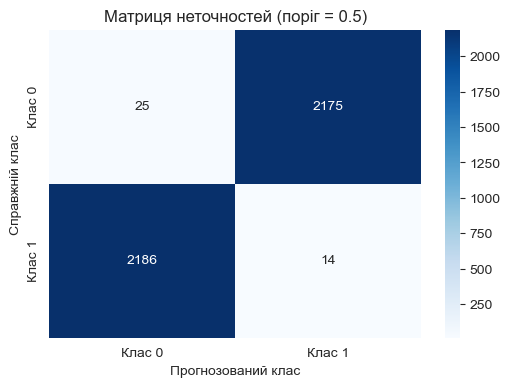

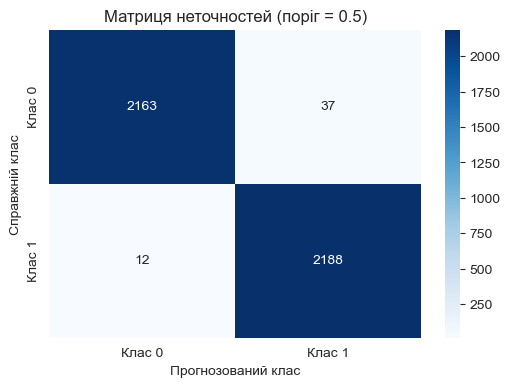

In [29]:
threshold = 0.5
y_pred = (model1_prob >= threshold).astype(int)

# Створення матриці
cm = confusion_matrix(y_true, y_pred)

# Візуалізація
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Клас 0', 'Клас 1'], yticklabels=['Клас 0', 'Клас 1'])
plt.xlabel('Прогнозований клас')
plt.ylabel('Справжній клас')
plt.title(f'Матриця неточностей (поріг = {threshold})')
plt.show()

y_pred2 = (model2_prob >= threshold).astype(int)

# Створення матриці
cm = confusion_matrix(y_true, y_pred2)

# Візуалізація
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Клас 0', 'Клас 1'], yticklabels=['Клас 0', 'Клас 1'])
plt.xlabel('Прогнозований клас')
plt.ylabel('Справжній клас')
plt.title(f'Матриця неточностей (поріг = {threshold})')
plt.show()

Обчислюємо метрики з відповідним порогом. Використовуємо вбудовану бібліотеку `sklearn.metrics` .

In [30]:
# Порогові значення, крок 0.01 для кращого відслідковування змін в метриках
thresholds = np.linspace(0, 1, 99)

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_pred, y_true) 
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred,zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    youden_j = recall + (confusion_matrix(y_true, y_pred)[0,0] / (confusion_matrix(y_true, y_pred)[0,0] + confusion_matrix(y_true, y_pred)[0,1])) - 1
    return {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "MCC": mcc,
        "Balanced Acc": balanced_acc,
        "Youden J": youden_j,
    }


Записуємо результати відповідно до моделей та порогу. Окремо обчислюємо AUC-PC та AUC-ROC, так як вони не залжеться вді значень порогу.

In [31]:
def all_metrics(y_true, model1_prob, model2_prob, thresholds):
    results_model1 = []
    results_model2 = []
    
    for thresh in thresholds:
        #(model1_prob >= 0.5) → [False, True, True, False]
        #.astype(int) → [0, 1, 1, 0]
    
        y_pred1 = (model1_prob >= thresh).astype(int)
        y_pred2 = (model2_prob >= thresh).astype(int)
        
        res1 = compute_metrics(y_true, y_pred1)
        res2 = compute_metrics(y_true, y_pred2)
        
        res1["Threshold"] = thresh
        res2["Threshold"] = thresh
        
        results_model1.append(res1)
        results_model2.append(res2)
    
    # Перетворення на DataFrame
    df_results1 = pd.DataFrame(results_model1)
    df_results2 = pd.DataFrame(results_model2)
    
    return df_results1, df_results2

df_results1, df_results2 = all_metrics(y_true, model1_prob, model2_prob, thresholds)

 Додавання AUC значень (не залежать від порогу)

In [32]:
def auc_metrics(y_true, model1_prob, model2_prob):
    auc_roc1 = roc_auc_score(y_true, model1_prob)
    auc_pr1 = average_precision_score(y_true, model1_prob)
    
    auc_roc2 = roc_auc_score(y_true, model2_prob)
    auc_pr2 = average_precision_score(y_true, model2_prob)
    
    return auc_pr1, auc_pr2, auc_roc1, auc_roc2

auc_pr1, auc_pr2, auc_roc1, auc_roc2 = auc_metrics(y_true, model1_prob, model2_prob)

Виведення результатів обчислення всіх метрик у вигляді таблиць.

In [33]:
def print_result(df_results1, df_results2, auc_roc1, auc_pr1, auc_roc2, auc_pr2): 
    print("Модель 1")
    print(tabulate(df_results1, headers='keys', tablefmt='grid'))
    print(f"AUC ROC: {auc_roc1:.4f}, AUC PR: {auc_pr1:.4f}")
    
    print("\nМодель 2")
    print(tabulate(df_results2, headers='keys', tablefmt='grid'))
    print(f"AUC ROC: {auc_roc2:.4f}, AUC PR: {auc_pr2:.4f}")
    
print_result(df_results1,df_results2, auc_roc1, auc_pr1, auc_roc2, auc_pr2)

Модель 1
+----+------------+-------------+-------------+-------------+-----------+----------------+------------+-------------+
|    |   Accuracy |   Precision |      Recall |          F1 |       MCC |   Balanced Acc |   Youden J |   Threshold |
+====+============+=============+=============+=============+===========+================+============+=============+
|  0 | 0.5        | 0.5         | 1           | 0.666667    |  0        |     0.5        |  0         |   0         |
+----+------------+-------------+-------------+-------------+-----------+----------------+------------+-------------+
|  1 | 0.232045   | 0.316412    | 0.461818    | 0.375531    | -0.603396 |     0.232045   | -0.535909  |   0.0102041 |
+----+------------+-------------+-------------+-------------+-----------+----------------+------------+-------------+
|  2 | 0.212273   | 0.297375    | 0.422273    | 0.348986    | -0.634093 |     0.212273   | -0.575455  |   0.0204082 |
+----+------------+-------------+-------------+

   2. Збудувати на одному графіку в одній координатній системі
(величина порогу; значення метрики) графіки усіх обчислених
метрик, відмітивши певним чином максимальне значення кожної
з них. 

Обчислює оптимальні пороги для кожної метрики у DataFrame.
Повертає словники: ключ = назва метрики, значення = (поріг, значення метрики) та ключ = поріг, значення = список метрик, для яких він є оптимальним.

In [34]:
def get_optimal_thresholds(df_results, threshold_col="Threshold"):
    metric_cols = [col for col in df_results.columns if col != threshold_col]
    best_thresholds = {}
    grouped_thresholds = defaultdict(list)

    for metric in metric_cols:
        idx = df_results[metric].idxmax()
        threshold = df_results.loc[idx, threshold_col]
        value = df_results.loc[idx, metric]
        best_thresholds[metric] = (threshold, value)
        grouped_thresholds[threshold].append(metric)
    
    return best_thresholds, grouped_thresholds

In [35]:
def summarize_best_thresholds_table(df_results, threshold_col="Threshold"):
    best_thresholds, _ = get_optimal_thresholds(df_results, threshold_col)
    
    # Перетворимо в список рядків для таблиці
    table_rows = []
    for metric, (threshold, value) in best_thresholds.items():
        table_rows.append({
            "Metric": metric,
            "Best Value": round(value, 6),
            "Threshold": round(threshold, 2)
        })

    # Сортуємо за назвою метрики для зручності
    df_summary = pd.DataFrame(table_rows).sort_values(by="Metric")

    # Виводимо таблицю
    print(tabulate(df_summary, headers="keys", tablefmt="github", showindex=False))

    return df_summary

In [36]:
def plot_metrics_over_thresholds(df_results, auc_pr, auc_roc, title="Metrics vs Threshold"):
    metrics_to_plot = [col for col in df_results.columns if col not in ["Threshold"]]
    
    plt.figure(figsize=(14, 8))

    for metric in metrics_to_plot:
        plt.plot(df_results["Threshold"], df_results[metric], label=metric)
        
    # Збір максимумів
    _, grouped_thresholds = get_optimal_thresholds(df_results)

    # Відображення унікальних максимумів
    for thresh, met_list in grouped_thresholds.items():
        y_vals = [df_results.loc[df_results["Threshold"] == thresh, m].values[0] for m in met_list]
        y_mean = sum(y_vals) / len(y_vals)
        plt.scatter(thresh, y_mean, s=80, color="red", zorder=5)
        
        label_text = f"Max @ {thresh:.2f}:\n" + ", ".join(met_list)
        plt.text(thresh, y_mean + 0.01, label_text, fontsize=9, ha='left', va='bottom')
    plt.axhline(auc_pr, color="orange", linestyle="--", label=f"AUC-PR = {auc_pr:.3f}")
    plt.axhline(auc_roc, color="cyan", linestyle="--", label=f"AUC-ROC = {auc_roc:.3f}")

    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 1.05)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
    plt.tight_layout()
    plt.show()

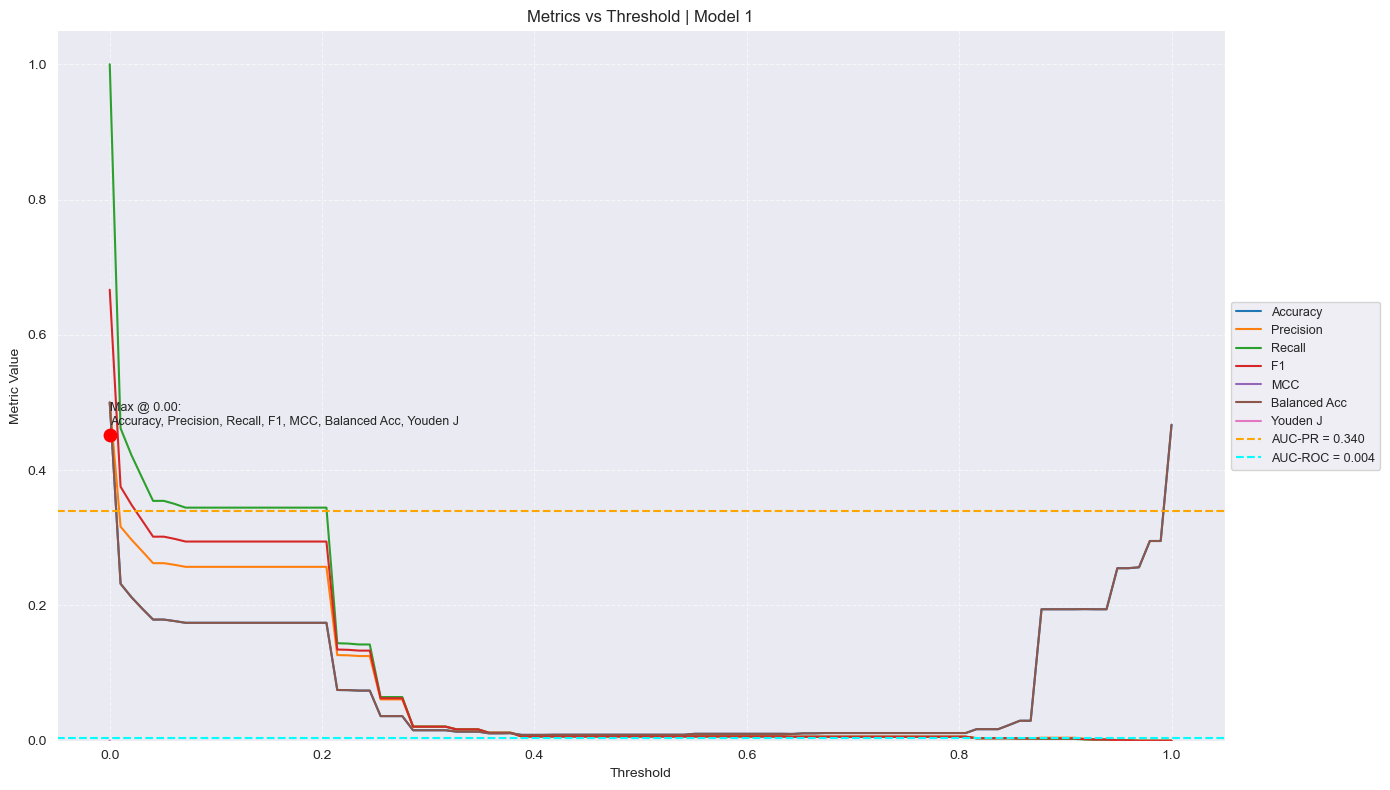

In [37]:
plot_metrics_over_thresholds(df_results1,auc_pr1,auc_roc1, title="Metrics vs Threshold | Model 1")

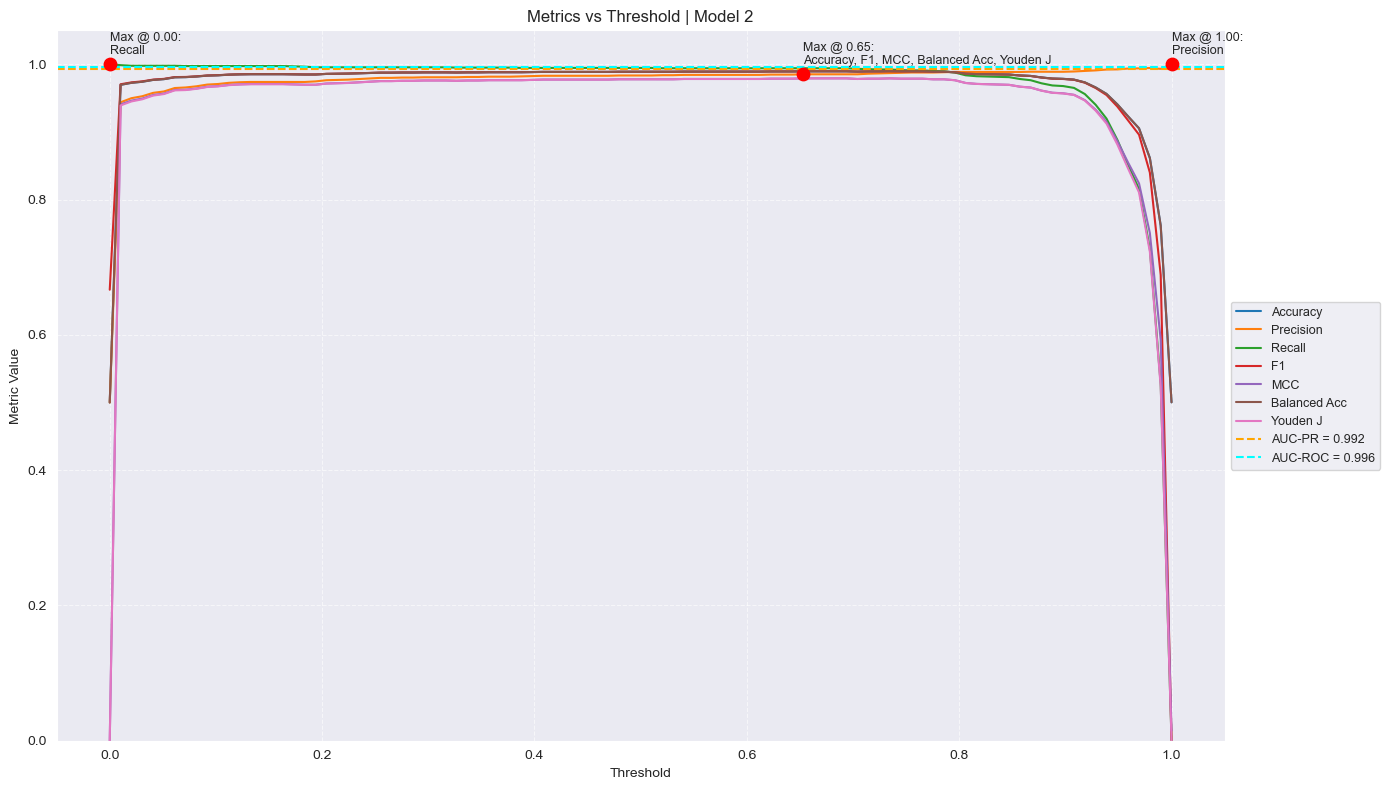

In [38]:
plot_metrics_over_thresholds(df_results2, auc_pr2, auc_roc2, title = "Metrics vs Threshold | Model 2")

 3. Збудувати в координатах (значення оцінки класифікаторів; 
кількість об’єктів кожного класу) окремі для кожного класу
графіки кількості об’єктів та відмітити вертикальними лініями
оптимальні пороги відсічення для кожної метрики.
  

In [39]:
def plot_score_distribution_kde(y_true, y_scores, title="Score Distribution"):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    best_thresholds, _ = get_optimal_thresholds(df_results1)

    plt.figure(figsize=(12, 6))

    # Побудова графіків щільності
    sns.kdeplot(y_scores[y_true == 0], label="Клас 0", color="skyblue", fill=True)
    sns.kdeplot(y_scores[y_true == 1], label="Клас 1", color="green", fill=True)

    # Вертикальні лінії для кожної метрики
    for metric, thresh in best_thresholds.items():
        plt.axvline(x=thresh[1], linestyle="--", label=f"{metric} = {thresh[1]:.2f}")

    plt.xlabel("Оцінка класифікатора (probability)")
    plt.ylabel("Щільність (кількість об’єктів кожного класу)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


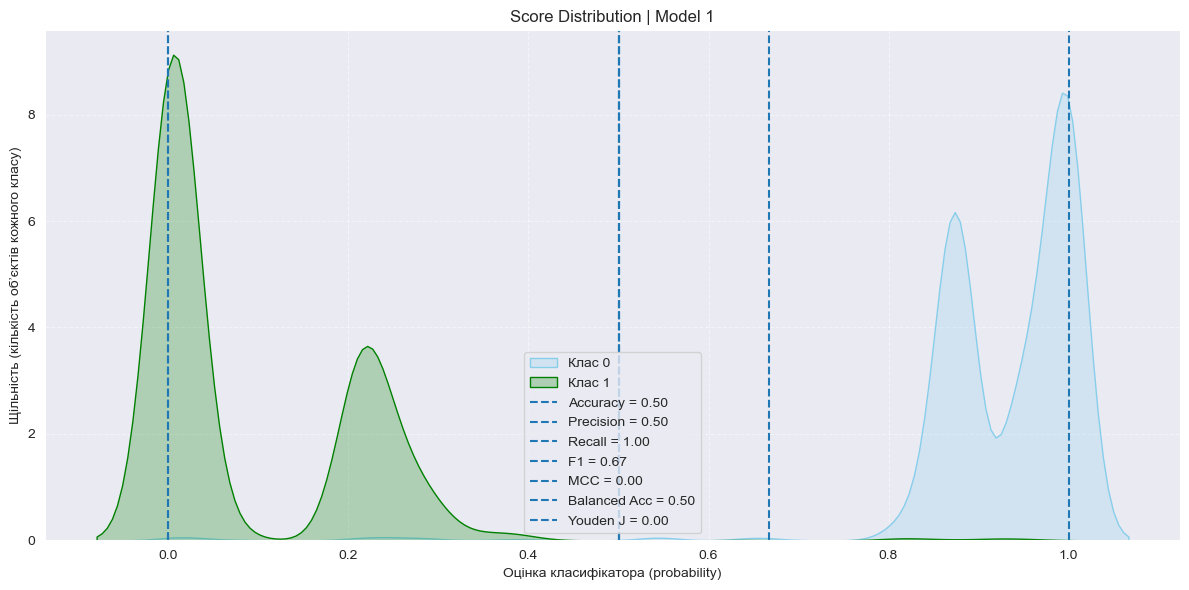

In [40]:
plot_score_distribution_kde(y_true, model1_prob, title="Score Distribution | Model 1")

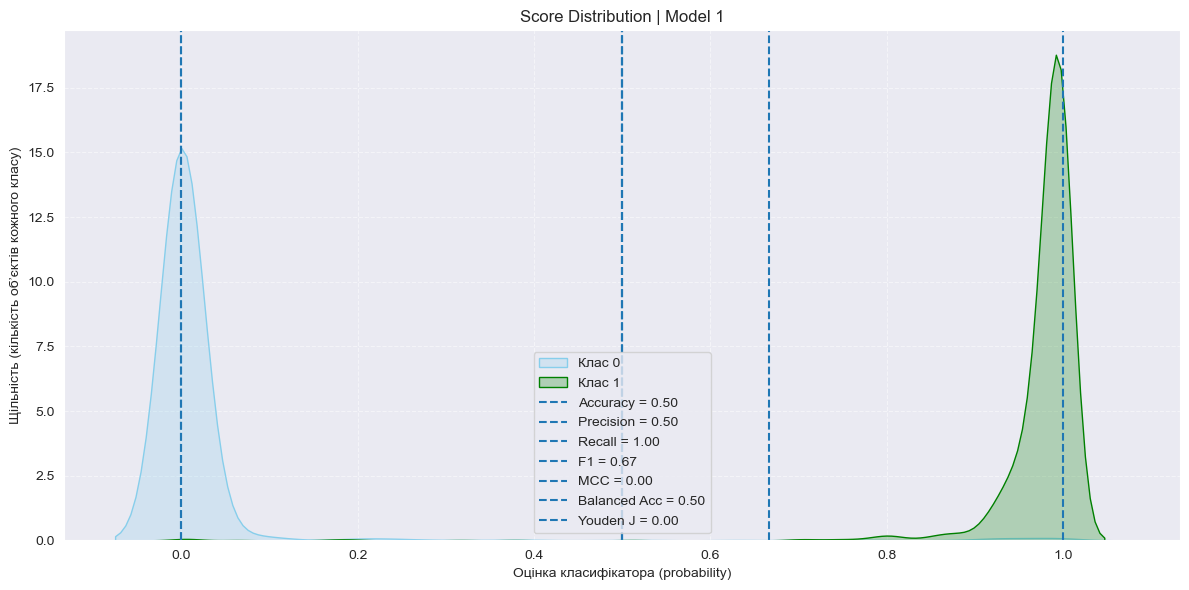

In [41]:
plot_score_distribution_kde(y_true, model2_prob, title="Score Distribution | Model 1")

  4. Збудувати для кожного класифікатору PR-криву та ROC-криву, 
показавши графічно на них значення оптимального порогу.

In [42]:
def plot_pr_roc_curves(y_true, y_scores, optimal_threshold, title_prefix="Model"):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    ### Precision-Recall ###
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Знайдемо найближчий поріг у PR-кривій
    idx_pr = np.argmin(np.abs(pr_thresholds - optimal_threshold))
    pr_point = (recall[idx_pr], precision[idx_pr])

    plt.figure(figsize=(12, 5))

    # --- PR-крива ---
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.3f})")
    plt.scatter(*pr_point, color='red', zorder=5, label=f"Optimal threshold = {optimal_threshold:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} | Precision-Recall Curve")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ### ROC ###
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Знайдемо найближчий поріг у ROC-кривій
    idx_roc = np.argmin(np.abs(roc_thresholds - optimal_threshold))
    roc_point = (fpr[idx_roc], tpr[idx_roc])

    # --- ROC-крива ---
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)
    plt.scatter(*roc_point, color='red', zorder=5, label=f"Optimal threshold = {optimal_threshold:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"{title_prefix} | ROC Curve")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

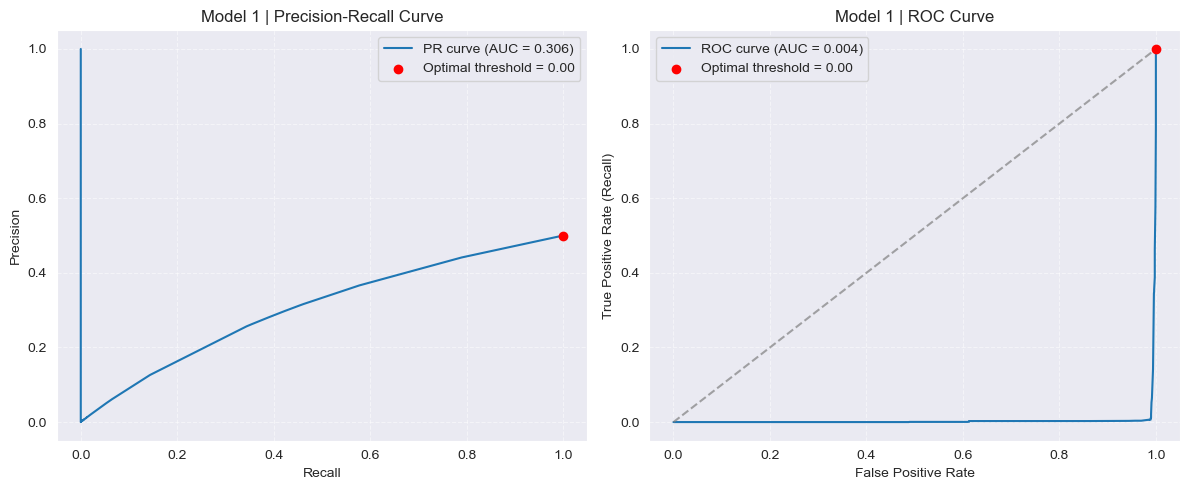

In [43]:
# Наприклад, вибираємо оптимальний поріг за метрикою F1
f1_idx = df_results1["F1"].idxmax()
opt_thresh1 = df_results1.loc[f1_idx, "Threshold"]

plot_pr_roc_curves(y_true, model1_prob, opt_thresh1, title_prefix="Model 1")

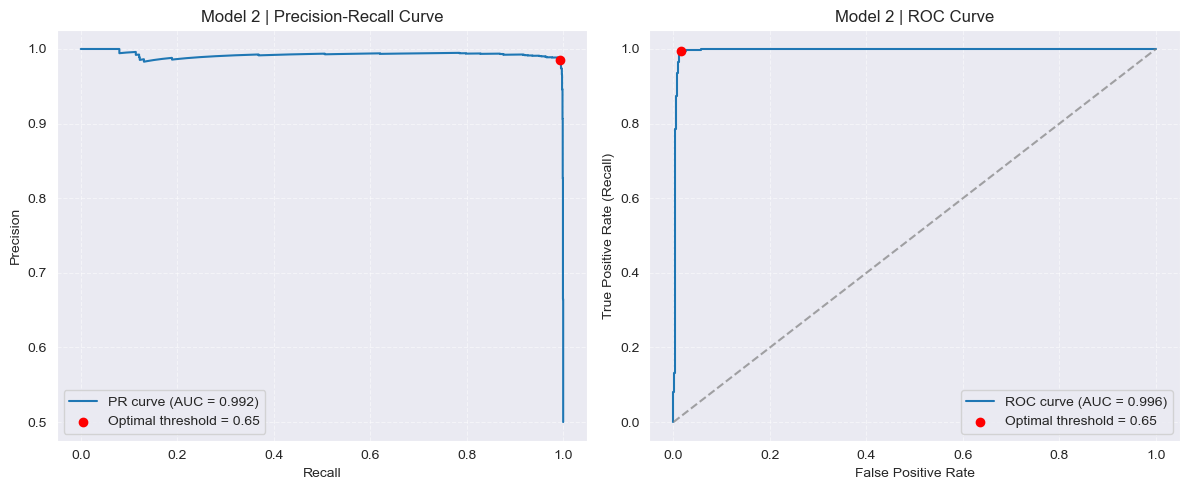

In [44]:
# Наприклад, вибираємо оптимальний поріг за метрикою F1
f2_idx = df_results2["F1"].idxmax()
opt_thresh2 = df_results2.loc[f2_idx, "Threshold"]

plot_pr_roc_curves(y_true, model2_prob, opt_thresh2, title_prefix="Model 2")

### **4. Зробити висновки щодо якості моделей, визначити кращу модель.**



In [45]:
summarize_best_thresholds_table(df_results1, threshold_col="Threshold")
summarize_best_thresholds_table(df_results2, threshold_col="Threshold")

print(f"Model 1\nAUC-PR: {auc_pr1}, AUC-ROC: {auc_roc1}\nModel 2\nAUC-PR: {auc_pr2}, AUC-ROC: {auc_roc2}")

| Metric       |   Best Value |   Threshold |
|--------------|--------------|-------------|
| Accuracy     |     0.5      |           0 |
| Balanced Acc |     0.5      |           0 |
| F1           |     0.666667 |           0 |
| MCC          |     0        |           0 |
| Precision    |     0.5      |           0 |
| Recall       |     1        |           0 |
| Youden J     |     0        |           0 |
| Metric       |   Best Value |   Threshold |
|--------------|--------------|-------------|
| Accuracy     |     0.989545 |        0.65 |
| Balanced Acc |     0.989545 |        0.65 |
| F1           |     0.989593 |        0.65 |
| MCC          |     0.979131 |        0.65 |
| Precision    |     1        |        1    |
| Recall       |     1        |        0    |
| Youden J     |     0.979091 |        0.65 |
Model 1
AUC-PR: 0.33966466111717275, AUC-ROC: 0.0039396694214876
Model 2
AUC-PR: 0.9922773710981229, AUC-ROC: 0.9957989669421488


З огляду на результати визначення метрик можна зазначити наступне: 

**Модель 1**

* Всі метрики, крім `Precision і Recall, F1-score`, досягають свого максимуму на порозі 0.98.

* `Precision` має максимум 0.316412 на порозі 0.01.

* `Recall` має максимум 0.461818 на порозі 0.01.

**Модель 2**

* Всі метрики, крім `Precision і Recall`, досягають свого максимуму на порозі 0.65.

* `Precision` має максимум 0.994379 на порозі 0.98.

* `Recall має` максимум 0.998636 на порозі 0.01.


Тобто,модель 2 буде значно кращою ніж модель 1. Модель 2 покаже кращу здатність розрізняти класи в умовах дисбалансу (значення AUC). В той час як в моделі 1 MCC = -0.507447, що свідчить про суперечливу оцінку моделі. Як варіант вирішення проблеми, можна відняти ймовірності від 1. Тоді ми отримаємо навпаки, результати будуть кращими ніж в моделі 2.

### **5. Створити новий набір даних, прибравши з початкового набору**
(50 + 10К)% об’єктів класу 1, вибраних випадковим чином. Параметр К
представляє собою залишок від ділення місяця народження студента на
чотири та має визначатися в програмі на основі дати народження
студента, яка задана в програмі у вигляді текстової змінної формату
‘DD-MM’.

In [46]:
birth_date_str = "29-11" 

month = int(birth_date_str.split("-")[1])

K = month % 4
percentage_to_remove = 50 + 10 * K
print(f"Місяць: {month}, K: {K}, видаляємо: {percentage_to_remove}% об'єктів класу 1")

# Фільтруємо об'єкти класу 1
class1_df = df[df["GT"] == 1]
class0_df = df[df["GT"] == 0]

n_to_remove = int(len(class1_df) * percentage_to_remove / 100)

# Випадково обираємо індекси для видалення
np.random.seed(42)  # для повторюваності
indices_to_remove = np.random.choice(class1_df.index, size=n_to_remove, replace=False)

class1_reduced = class1_df.drop(indices_to_remove)

# Об'єднуємо з класом 0
new_df = pd.concat([class0_df, class1_reduced]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Новий розмір датасету: {new_df.shape}, кількість класу 1: {sum(new_df['GT'] == 1)}")


Місяць: 11, K: 3, видаляємо: 80% об'єктів класу 1
Новий розмір датасету: (2640, 3), кількість класу 1: 440


### **6. Вивести відсоток видалених об’єктів класу 1 та кількість елементів кожного класу після видалення**

In [47]:
n_class1_before = sum(df["GT"] == 1)
n_class1_after = sum(new_df["GT"] == 1)
n_class0_after = sum(new_df["GT"] == 0)

removed_percentage = 100 * (n_class1_before - n_class1_after) / n_class1_before

print(f"Видалено {removed_percentage:.2f}% об'єктів класу 1")
print(f"Кількість класу 1 після видалення: {n_class1_after}")
print(f"Кількість класу 0 після видалення: {n_class0_after}")

Видалено 80.00% об'єктів класу 1
Кількість класу 1 після видалення: 440
Кількість класу 0 після видалення: 2200


### **7. Виконати дії п.3 для нового набору даних**

0    0.833333
1    0.166667
Name: proportion, dtype: float64
Model 1
AUC-PR: 0.9795612153974416, AUC-ROC: 0.9971632231404959
Model 2
AUC-PR: 0.9642782012566694, AUC-ROC: 0.9958305785123968
| Metric       |   Best Value |   Threshold |
|--------------|--------------|-------------|
| Accuracy     |     0.99053  |        0.59 |
| Balanced Acc |     0.993409 |        0.59 |
| F1           |     0.972315 |        0.59 |
| MCC          |     0.967064 |        0.59 |
| Precision    |     0.981203 |        0.97 |
| Recall       |     1        |        0    |
| Youden J     |     0.986818 |        0.59 |
| Metric       |   Best Value |   Threshold |
|--------------|--------------|-------------|
| Accuracy     |     0.989015 |        0.76 |
| Balanced Acc |     0.991591 |        0.76 |
| F1           |     0.967956 |        0.76 |
| MCC          |     0.961868 |        0.76 |
| Precision    |     1        |        1    |
| Recall       |     1        |        0    |
| Youden J     |     0.983182

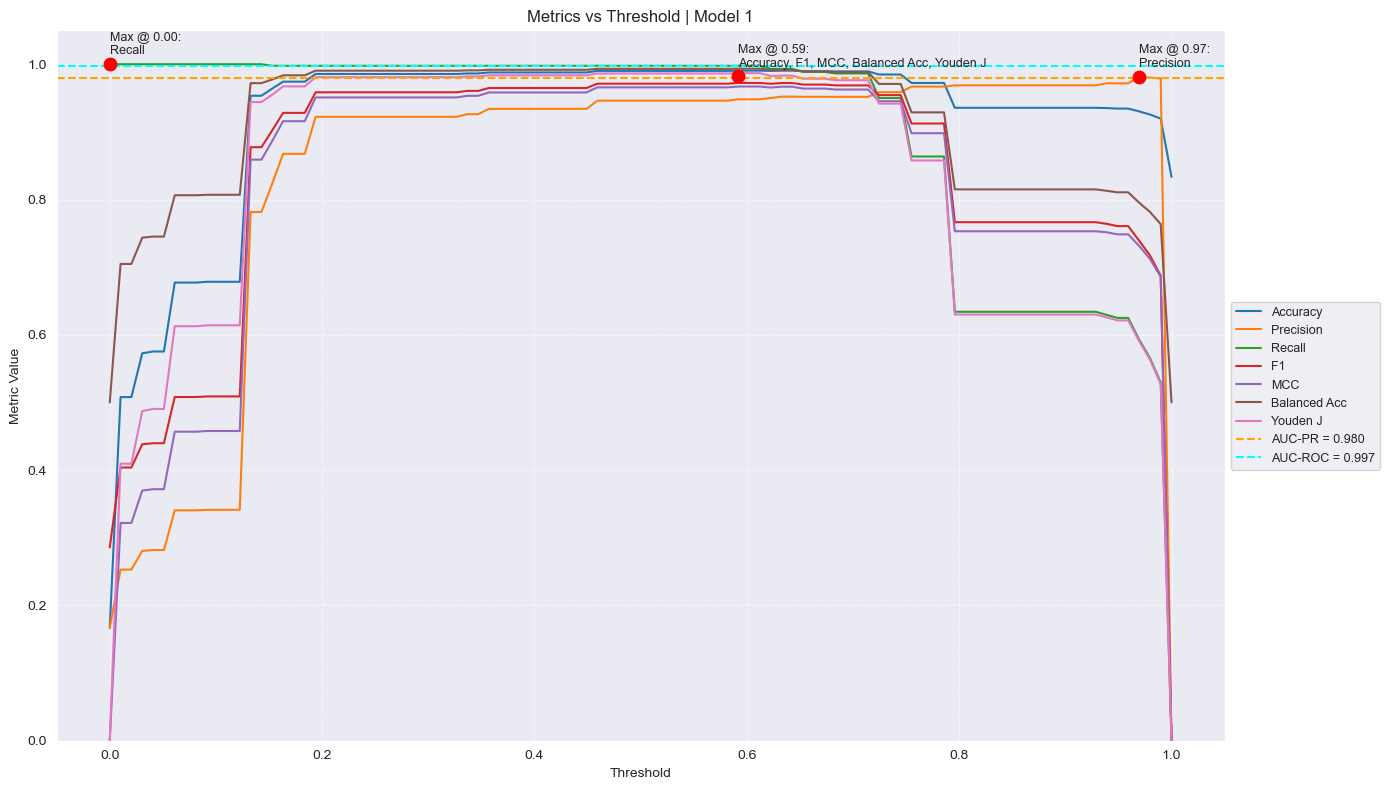

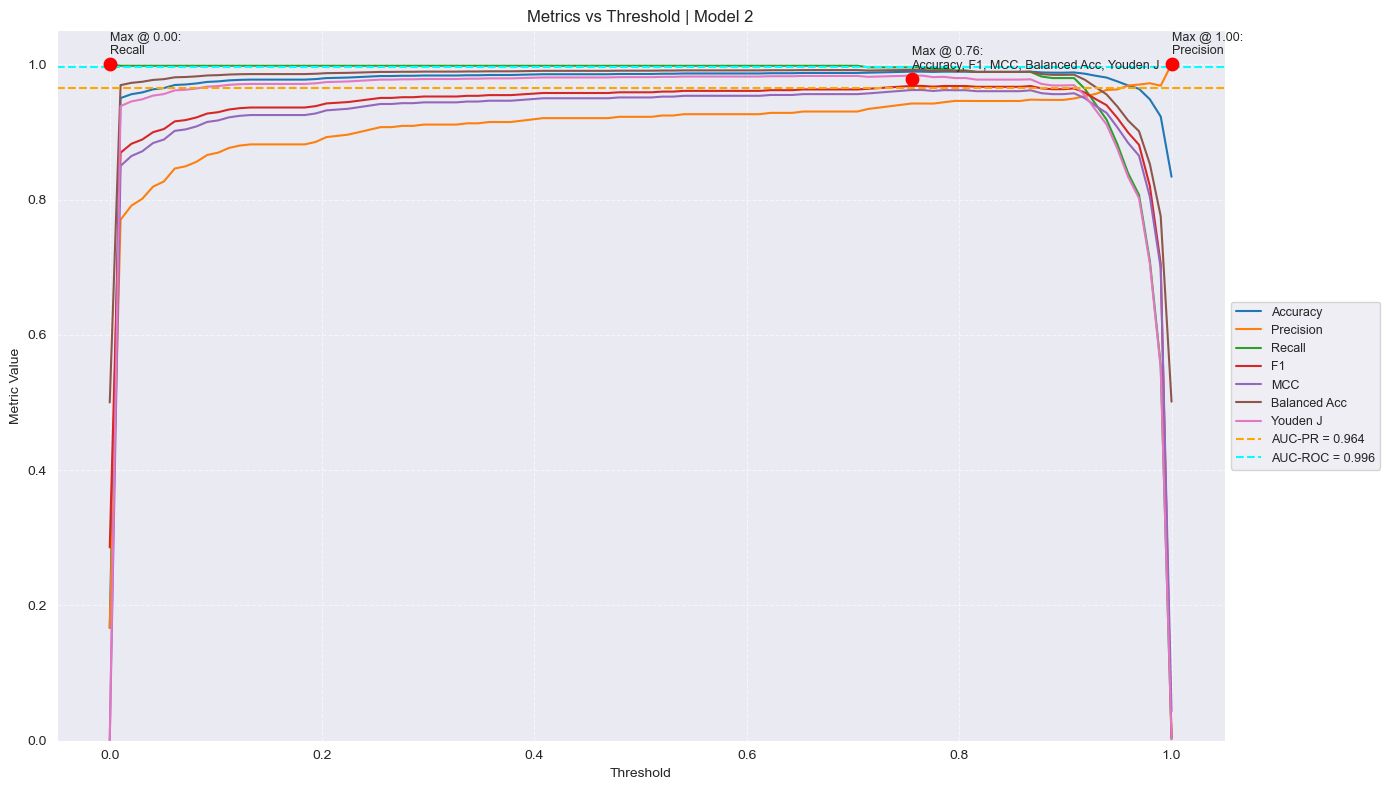

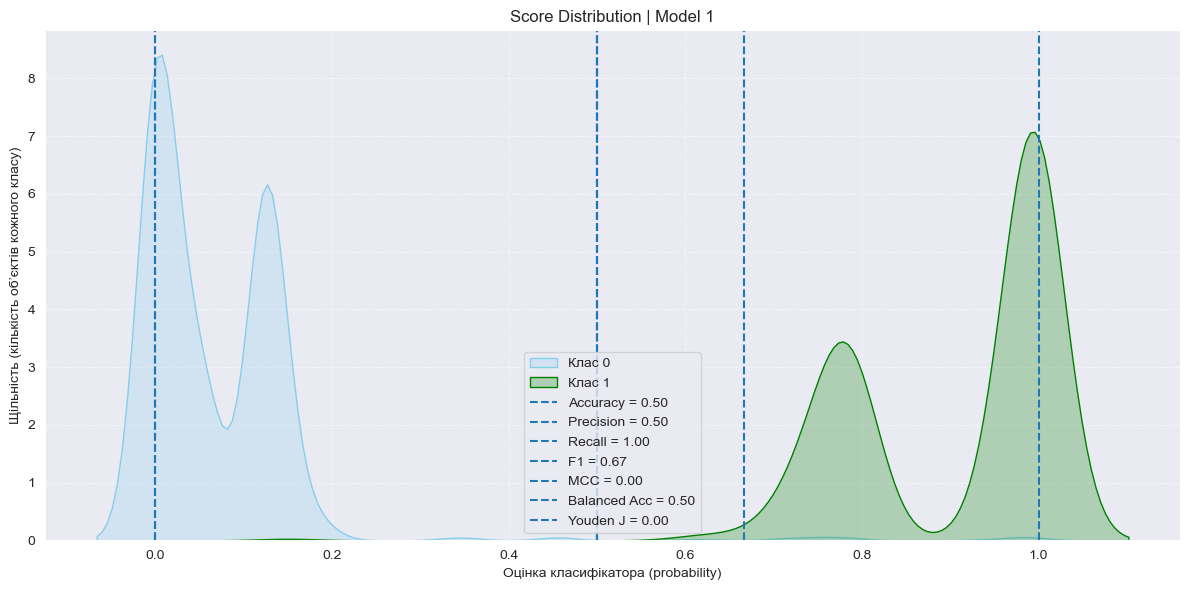

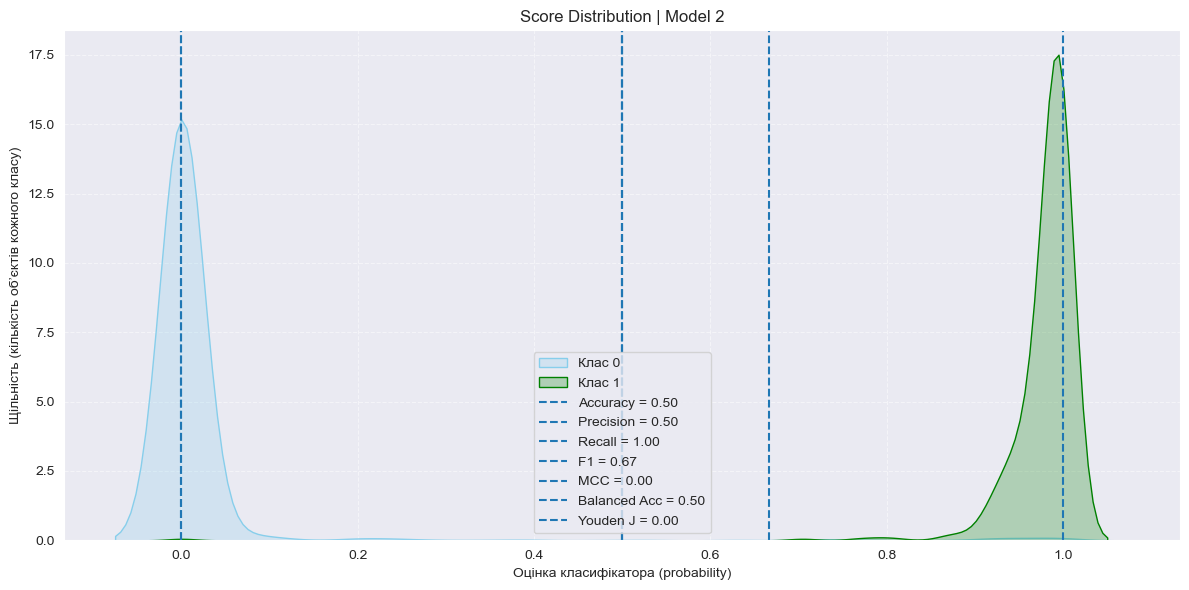

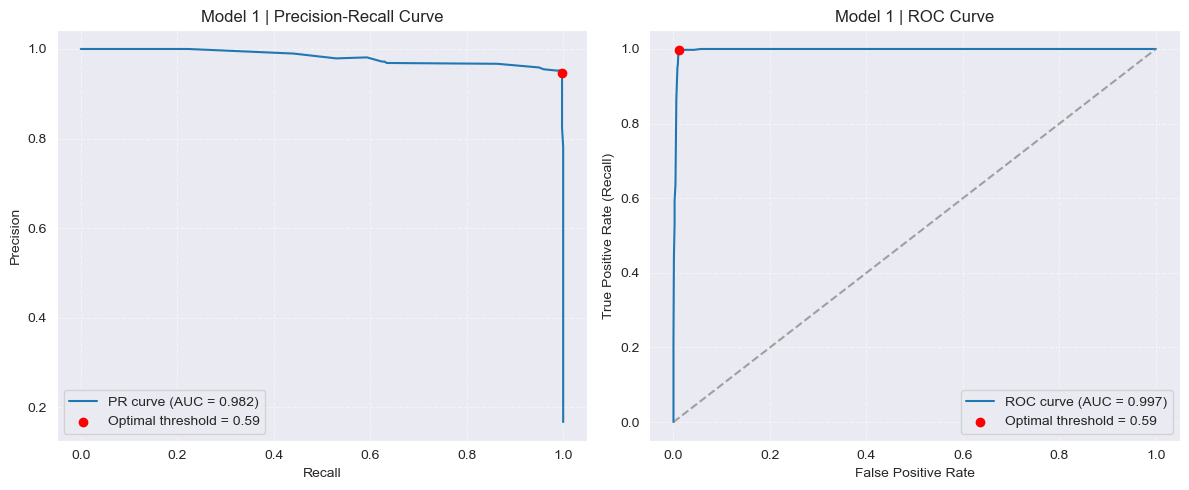

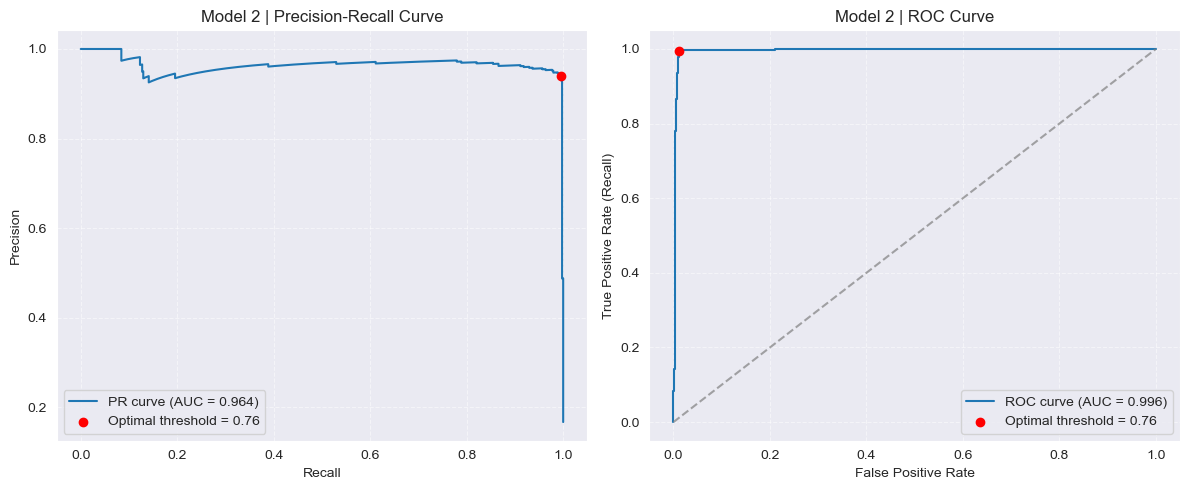

In [48]:
def process_new_dataset(new_df, thresholds):
    # Визначення справжніх міток та ймовірностей
    y_true_new = new_df["GT"].values
    model1_prob_new = 1 - new_df["Model_1_0"].values  # ймовірність класу 0
    model2_prob_new = new_df["Model_2_1"].values      # ймовірність класу 1
    print(pd.Series(y_true_new).value_counts(normalize=True))
    
    # Обчислення метрик для різних порогів
    df_results1_new, df_results2_new = all_metrics(y_true_new, model1_prob_new, model2_prob_new, thresholds)

    # Обчислення AUC метрик
    auc_pr1_new, auc_pr2_new, auc_roc1_new, auc_roc2_new = auc_metrics(y_true_new, model1_prob_new, model2_prob_new)
    print(f"Model 1\nAUC-PR: {auc_pr1_new}, AUC-ROC: {auc_roc1_new}\nModel 2\nAUC-PR: {auc_pr2_new}, AUC-ROC: {auc_roc2_new}")
   # print_result(df_results1_new, df_results2_new, auc_roc1_new, auc_pr1_new, auc_roc2_new, auc_pr2_new)

    # Виведення таблиць з оптимальними порогами
    summarize_best_thresholds_table(df_results1_new, threshold_col="Threshold")
    summarize_best_thresholds_table(df_results2_new, threshold_col="Threshold")

    # Побудова графіків метрик від порогу
    plot_metrics_over_thresholds(df_results1_new, auc_pr1_new, auc_roc1_new, title="Metrics vs Threshold | Model 1")
    plot_metrics_over_thresholds(df_results2_new, auc_pr2_new, auc_roc2_new, title="Metrics vs Threshold | Model 2")

    # Побудова графіків розподілу оцінок
    plot_score_distribution_kde(y_true_new, model1_prob_new, title="Score Distribution | Model 1")
    plot_score_distribution_kde(y_true_new, model2_prob_new, title="Score Distribution | Model 2")

    # Побудова PR та ROC кривих
    f1_idx_new = df_results1_new["F1"].idxmax()
    opt_thresh1_new = df_results1_new.loc[f1_idx_new, "Threshold"]
    plot_pr_roc_curves(y_true_new, model1_prob_new, opt_thresh1_new, title_prefix="Model 1")

    f2_idx_new = df_results2_new["F1"].idxmax()
    opt_thresh2_new = df_results2_new.loc[f2_idx_new, "Threshold"]
    plot_pr_roc_curves(y_true_new, model2_prob_new, opt_thresh2_new, title_prefix="Model 2")

process_new_dataset(new_df, thresholds)

### **9. Пояснити вплив незбалансованості набору даних на прийняте рішення.**

Незбалансованість набору даних означає, що одна з категорій (класів) значно переважає іншу за кількістю прикладів. 
У даному випадку, після видалення значної частини об'єктів класу 1, він стає суттєво менш представленим у порівнянні з класом 0.

Це має такі наслідки:

1. **Схильність до домінування більшого класу** — класифікатор може "навчитись" просто передбачати переважаючий клас і отримувати високу точність, нехтуючи меншістю.

2. **Зниження метрик для класу меншості** — precision, recall, F1-score для класу 1 можуть значно погіршитися. Наприклад, recall (виявлення позитивних випадків) буде низьким.

3. **Зміщення оптимальних порогів** — через рідкість класу 1, оптимальні пороги метрик (наприклад, F1 або MCC) можуть зміститися ближче до нуля, щоб вловити хоч якісь позитивні передбачення.

4. **Потрібні спеціальні стратегії**:
   - використання ваг класів;
   - ресемплінг;
   - застосування метрик, стійких до незбалансованості (наприклад, AUC-PR, MCC, balanced accuracy).

Таким чином, незбалансованість суттєво впливає на результати та інтерпретацію моделі, і це слід враховувати при виборі моделі та метрик оцінювання.
